In [1]:
import transformers
import pandas as pd
import numpy as np
import nltk
from utils import TweetsDataset, Results
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from collections import defaultdict
import numpy as np
import torch
import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Carga del tokenizador 

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4, problem_type="multi_label_classification")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

## Conjunto de datos

In [3]:
df = pd.read_csv("../../data/procesed.csv")
df_train, df_valid = TweetsDataset.split_test_val(df,test_size=0.20,valid_size=0.20)
train_data_loader = TweetsDataset.create_data_loader(df_train, tokenizer, batch_size=8)
valid_data_loader = TweetsDataset.create_data_loader(df_valid, tokenizer, batch_size=8)

## Parámetros del entrenamiento

In [4]:
model = model.to(device)
EPOCHS = 8
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(df_train) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, 
    num_training_steps = total_steps
)

## Entrenamiento del modelo

In [5]:
import torch.nn.functional as F
import sys

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for i,d in enumerate(data_loader):
        print("Entrenando " + "."*(i%4), end="\r")
        loss, logits = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device),
            labels=F.one_hot(d['labels'].to(device), num_classes=4).float(),
            return_dict=False
        )
        logits = logits.detach().cpu().numpy()
        label_ids = d['labels'].cpu().flatten().numpy()
        preds = np.argmax(logits, axis=1).flatten()
        targ = d['labels'].numpy()
        correct_predictions += np.sum(preds==targ)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        sys.stdout.write("\033[K")
    return correct_predictions / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            loss, logits = model(
                input_ids = d["input_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d['labels'].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
        return correct_predictions / n_examples, np.mean(losses)

In [6]:
from collections import defaultdict
history = defaultdict(list)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-'*10)   
    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} Accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, valid_data_loader, device, len(df_valid))
    print(f'Val loss {val_loss} Accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epoch 1/8
----------
Train loss 0.5411943753949957 Accuracy 0.3477941176470588
Val loss 0.5359038164218267 Accuracy 0.3638888888888889
Epoch 2/8
----------
Train loss 0.5375645097564249 Accuracy 0.34787581699346404
Val loss 0.5356752613076458 Accuracy 0.3638888888888889
Epoch 3/8
----------
Train loss 0.5377361907873278 Accuracy 0.34991830065359475
Val loss 0.535573324781877 Accuracy 0.3638888888888889
Epoch 4/8
----------
Train loss 0.5367306807461907 Accuracy 0.35669934640522877
Val loss 0.5351145919826296 Accuracy 0.3638888888888889
Epoch 5/8
----------
Train loss 0.5370723249670727 Accuracy 0.3497549019607843
Val loss 0.5353038600197545 Accuracy 0.3638888888888889
Epoch 6/8
----------
Train loss 0.5369652122648713 Accuracy 0.3486928104575163
Val loss 0.5355646343142898 Accuracy 0.3638888888888889
Epoch 7/8
----------
Train loss 0.5366119274126938 Accuracy 0.3524509803921569
Val loss 0.5352958830418411 Accuracy 0.3638888888888889
Epoch 8/8
----------
Train loss 0.5365842438016841 Ac

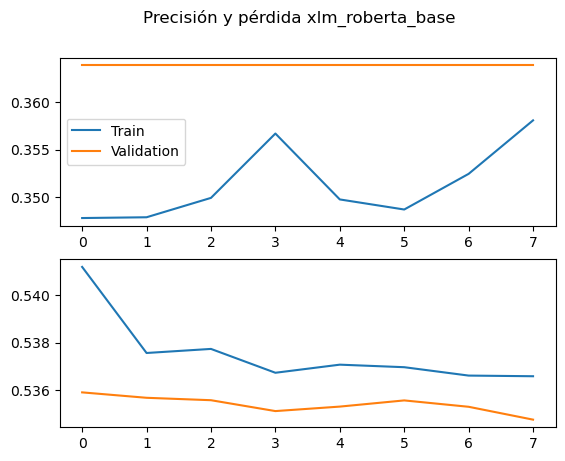

In [7]:
torch.save(model.state_dict(), 'xlm_roberta_base.bin')
Results.plot_train_history(history, 'xlm_roberta_base')

## Prueba del modelo

In [14]:
from utils import Results, TweetsDataset
model = transformers.XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=4, problem_type="multi_label_classification")
model.to(device)
model.load_state_dict(torch.load('xlm_roberta_base.bin'))
df_test = pd.read_csv('../../data/development_test.csv')
df_test = pd.DataFrame({
    "tweets": df_test["tweet"],
    "labels": df_test["ideology_multiclass"].map({'moderate_left': 0, 'moderate_right': 1, "left": 2, "right": 3})
})
test_data_loader = TweetsDataset.create_data_loader(df_test, tokenizer)
acc, loss, f1 = test(model, test_data_loader, device, len(df_test))
Results.add_result("xml-roberta-base", "ideology-multiclass", acc, loss, f1)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

KeyError: 'iput_ids'

In [11]:
def test(model, test_data_loader, device, test_len):
    model = model.eval()
    correct_predictions = 0
    losses = []
    with torch.no_grad():
        for d in test_data_loader:
            loss, logits = model(
                input_ids = d["iput_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d["labels"].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
    return correct_predictions / test_len, np.mean(losses)